In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import *
from nbodykit import style, setup_logging
import matplotlib.pyplot as plt
plt.style.use(style.notebook)
import gc
import pandas as pd
import nbodykit as nb
from nbodykit.lab import ArrayCatalog  

In [2]:
data_read = pd.read_csv('./Ne_Galaxy_Mstar10_ver2.csv')

In [3]:
data_jk_o = data_read[['X','Y','Z','Vx','Vy','Vz','Mass']]
data_jk = np.array(data_jk_o)

In [4]:
struct_dtype = np.dtype([
    ('Pos', np.float32, 3),
    ('Vel', np.float32, 3),
    ('CentralMvir', np.float32),
])
jk_struct = np.empty(data_jk.shape[0], dtype=struct_dtype)

jk_struct['Pos']         = data_jk[:, 0:3]
jk_struct['Vel']         = data_jk[:, 3:6]
jk_struct['CentralMvir'] = data_jk[:, 6]

In [5]:

#const
LOS=[1,0,0]
z_eff=0

#cos
cosmo = cosmology.Planck15
H=cosmo.efunc(z_eff)*100
a=1/(1+z_eff)
def RED(cat):
    line_of_sight_x=(1,0,0)
    cat['vel_x']=cat['Vel']*line_of_sight_x/(a*H)

    cat['RsdPos_x']=cat['Pos']+(cat['vel_x']*line_of_sight_x)
    cat['Vx'] = cat['Vel'][:,0]
    return cat

In [6]:
jk_np = jk_struct
min_mvir = 3 
mask = jk_struct['CentralMvir'] > 10**min_mvir
jk_np = jk_np[mask]
jk_struct = nb.source.catalog.ArrayCatalog(jk_np)


In [7]:
print(jk_np.shape)

(4553,)


In [8]:
def momentum(cat,BoxSize=200):
    LOS = [1,0,0]
    cat['Vx'] = (cat['Vel'] @ LOS) 
    momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='Pos', value='Vx')
    mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='Pos')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    return r01, P01

In [25]:
jk_struct = RED(jk_struct)

cat_all = jk_struct 
BoxSize = 205         
nside   = (8, 8, 8)              
LOS_vec = np.array([1, 0, 0], dtype=np.float32)

In [26]:
#test
# LOS = [1,0,0]
# jk_struct['Vx'] = (jk_struct['Vel'] @ LOS) 

momentum_mesh_test = jk_struct.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x', value='Vx')
mesh_test = jk_struct.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x')
print(type(momentum_mesh_test))


<class 'nbodykit.source.mesh.catalog.CatalogMesh'>


In [11]:
#test
print(mesh_test.base)

None


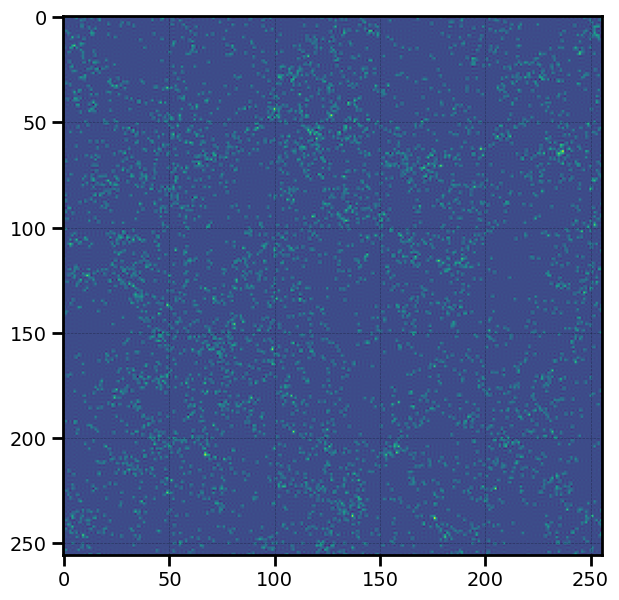

In [12]:
#test
one_plus_delta = mesh_test.paint(mode='real')
plt.imshow(one_plus_delta.preview(axes=[0,1]))

In [13]:
r_full, P_full = momentum(cat_all, BoxSize=BoxSize)
k_mid = r_full.poles['k']
Nk    = k_mid.size
B = 512
P_blocks = np.empty((B, Nk), dtype=np.float32)

In [14]:
step = 32
field_momentum = momentum_mesh_test.to_field()
value_momentum = field_momentum.value
field_mesh = mesh_test.to_field()
value_mesh = field_mesh.value
b = 0
LOS=[1,0,0]


for i in range(8):
    for j in range(8):
        for k in range(8):
            slc = (slice(i*step,(i+1)*step),
                   slice(j*step,(j+1)*step),
                   slice(k*step,(k+1)*step))
            
            backup_momentum = value_momentum[slc].copy()
            backup_mesh = value_mesh[slc].copy()
            value_momentum[slc] = 0
            value_mesh[slc] = 0

            r01 = FFTPower(field_momentum, mode='1d', poles=[1], second=field_mesh, los=LOS)
            P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
            P_blocks[b] = P01
            b += 1

            value_momentum[slc] = backup_momentum
            value_mesh[slc] = backup_mesh



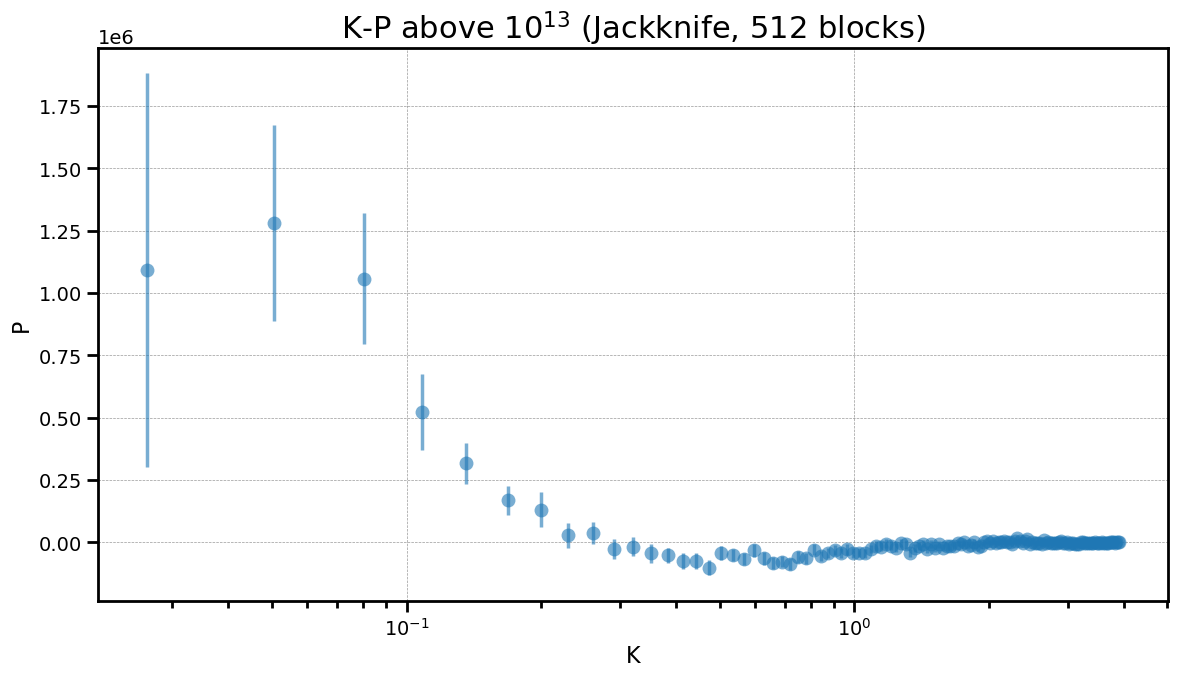

In [15]:
P_mean = P_blocks.mean(axis=0)
diff   = P_blocks - P_mean
cov_jk = (B - 1) / B * diff.T @ diff   
var_jk = np.diag(cov_jk)                
sigma  = np.sqrt(var_jk)
plt.figure()
# idx_skip = 0
# idx_skip_2 = 0                
# mask = (np.arange(k_mid.size) != idx_skip) & idx_skip_2
plt.errorbar(k_mid, P_mean, yerr=sigma,
             fmt='o', capsize=3, alpha=0.6,
             label='data (mean)')

plt.xscale('log')
plt.xlabel('K')
plt.ylabel('P')
plt.title(fr'K-P above $10^{{{10+min_mvir}}}$ (Jackknife, 512 blocks)')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

In [16]:
# nx, ny, nz = nside
# B          = nx * ny * nz                           
# block_len  = BoxSize / np.array(nside, dtype=np.float32)
# pos = (cat_all['Pos'].compute() % BoxSize).astype(np.float32)
# idx = np.floor(pos / block_len).astype(np.int64) % np.array(nside)
# bid = idx[:, 0] + nx*idx[:, 1] + nx*ny*idx[:, 2] 
# r_full, P_full = momentum(cat_all, BoxSize=BoxSize)
# k_mid = r_full.poles['k']
# Nk    = k_mid.size
# P_blocks = np.empty((B, Nk), dtype=np.float32)
# for b in range(B):
#     mask = (bid != b)                        
#     sub_cat = nb.source.catalog.ArrayCatalog(jk_np[mask]) 
#     _, P_b  = momentum(sub_cat, BoxSize=BoxSize)
#     P_blocks[b] = P_b

In [17]:
# P_mean = P_blocks.mean(axis=0)
# diff   = P_blocks - P_mean
# cov_jk = (B - 1) / B * diff.T @ diff   
# var_jk = np.diag(cov_jk)                
# sigma  = np.sqrt(var_jk)

In [18]:
# print("k (前 6 个):", k_mid[:6])

In [19]:
# plt.figure()
# # idx_skip = 0
# # idx_skip_2 = 0                
# # mask = (np.arange(k_mid.size) != idx_skip) & idx_skip_2
# plt.errorbar(k_mid, P_mean, yerr=sigma,
#              fmt='o', capsize=3, alpha=0.6,
#              label='data (mean)')

# plt.xscale('log')
# plt.xlabel('K')
# plt.ylabel('P')
# plt.title(fr'K-P above $10^{{{10+min_mvir}}}$ (Jackknife, 512 blocks)')
# plt.grid(True, alpha=0.4)
# plt.tight_layout()
# plt.show()

In [20]:

#const
LOS=[1,0,0]
z_eff=0

#cos
cosmo = cosmology.Planck15
H=cosmo.efunc(z_eff)*100
a=1/(1+z_eff)
def RED(cat):
    line_of_sight_x=(1,0,0)
    cat['vel_x']=cat['Vel']*line_of_sight_x/(a*H)

    cat['RsdPos_x']=cat['Pos']+(cat['vel_x']*line_of_sight_x)
    cat['Vx'] = cat['Vel'][:,0]
    return cat

In [21]:
cat_RSD = RED(jk_struct)

In [22]:
def momentum_01(cat, gamma=None, cache=True):
    if 'weight' not in cat:
        cat['weight'] = 1
    if 'RsdPos_x' in cat:
        LOS=(1,0,0)
        cat['RsdPos_x'] = cat['RsdPos_x']%200
        momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
        mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=200, window='tsc', position='RsdPos_x')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    return r01, P01

In [23]:
r01, P01 = momentum_01(cat=cat_RSD)

/tmp/ipykernel_2951323/4111753040.py:7: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
/tmp/ipykernel_2951323/4111753040.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=200, window='tsc', position='RsdPos_x')


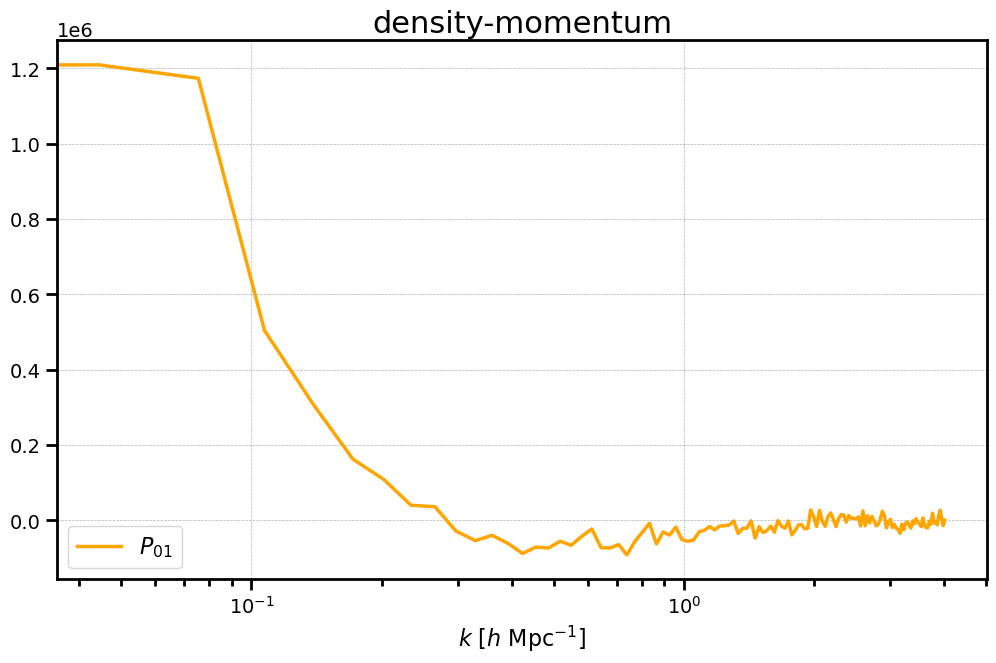

In [24]:
plt.loglog(r01.power['k'], P01, label=r"$P_{01}$", color='orange')
plt.title("density-momentum")
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.6)
plt.yscale('linear')